# **Few-Shots Learning with Prototypical Networks**

## Apprentissage profond et traitement du signal - MVA 

### Auteurs: Naïl Khelifa et Quentin Moayedpour

#### Chargement des librairies

In [1]:
## classique 

import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import torch
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

## handmade
import src.train as train
import src.test_model as test
from src.proto_encoder import PrototypeEncoder

## 1. **Entraînement de l'encodeur**

On commence par charger les données d'entraînement, que l'on va plus tard utiliser pour entraîner le modèle de few-shot learning en question. 

### Few-Shot Classification

In few-shot classification we are given a small support set of $ N $ labeled examples $ S = \{(x_1, y_1), \dots, (x_N, y_N)\} $, where each $ x_i \in \mathbb{R}^D $ is the $ D $-dimensional feature vector of an example and $ y_i \in \{1, \dots, K\} $ is the corresponding label. $ S_k $ denotes the set of examples labeled with class $ k $.

### Prototypical Networks classification

Prototypical networks compute an $ M $-dimensional representation $ c_k \in \mathbb{R}^M $, or prototype, of each class through an embedding function $ f_\phi : \mathbb{R}^D \to \mathbb{R}^M $ with learnable parameters $ \phi $. Each prototype is the mean vector of the embedded support points belonging to its class:

$$
c_k = \frac{1}{|S_k|} \sum_{(x_i, y_i) \in S_k} f_\phi(x_i) \tag{1}
$$

Given a distance function $ d : \mathbb{R}^M \times \mathbb{R}^M \to [0, +\infty) $, prototypical networks produce a distribution over classes for a query point $ x $ based on a softmax over distances to the prototypes in the embedding space:

$$
p_\phi(y = k \mid x) = \frac{\exp(-d(f_\phi(x), c_k))}{\sum_{k'} \exp(-d(f_\phi(x), c_{k'}))} \tag{2}
$$

Learning proceeds by minimizing the negative log-probability:

$$
J(\phi) = -\log p_\phi(y = k \mid x)
$$

of the true class $ k $ via stochastic gradient descent (SGD). Training episodes are formed by randomly selecting a subset of classes from the training set, then choosing a subset of examples within each class to act as the support set and a subset of the remainder to serve as query points. 


In [2]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0'  # Whether to use CUDA for computation
}

In [3]:
model, best_acc, train_loss, train_acc = train.main(opt)

=== Epoch: 0 ===


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Avg Train Loss: 1.114461681842804, Avg Train Acc: 0.42219999834895133
=== Epoch: 1 ===


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Avg Train Loss: 0.7269027948379516, Avg Train Acc: 0.6174999988079071
=== Epoch: 2 ===


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Avg Train Loss: 0.5946785029768944, Avg Train Acc: 0.6740000033378601
=== Epoch: 3 ===


100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


Avg Train Loss: 0.5845928499102593, Avg Train Acc: 0.6636000001430511
=== Epoch: 4 ===


100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Avg Train Loss: 0.5495801907777786, Avg Train Acc: 0.6780000019073487
Final model saved to ../logs/last_model.pth


On a $\texttt{x\_enroll.size() = torch.Size([500, 2, 2048])}$ donc on dispose de 500 échantillons pour enrôler les nouvelles classes. C'est peut-être inutilement grand. On se propose donc d'observer ce qu'il se passe si on réduit l'enrollement lors du calcul des prototypes.

/home/onyxia/work/PrototypicalFewShots/src/test_model.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch

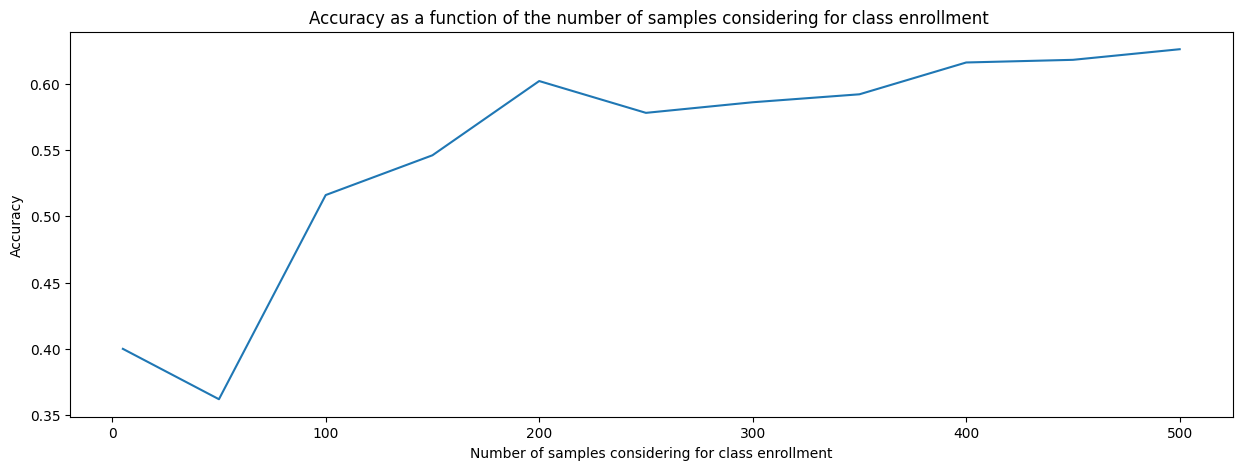

In [4]:
enroll_list = [5, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
acc_list = []

for n_enroll in enroll_list: 

    model_path = "../logs/last_model_Ns20_Nq20_cl5_ep50.pth"
    data_path = "../data"
    acc = test.test_acc(model_path, n_enroll, data_path)
    acc_list.append(acc)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(enroll_list, acc_list)
ax.set_xlabel("Number of samples considering for class enrollment")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy as a function of the number of samples considering for class enrollment ")

fig.show()

100%|██████████| 8/8 [00:17<00:00,  2.16s/it]


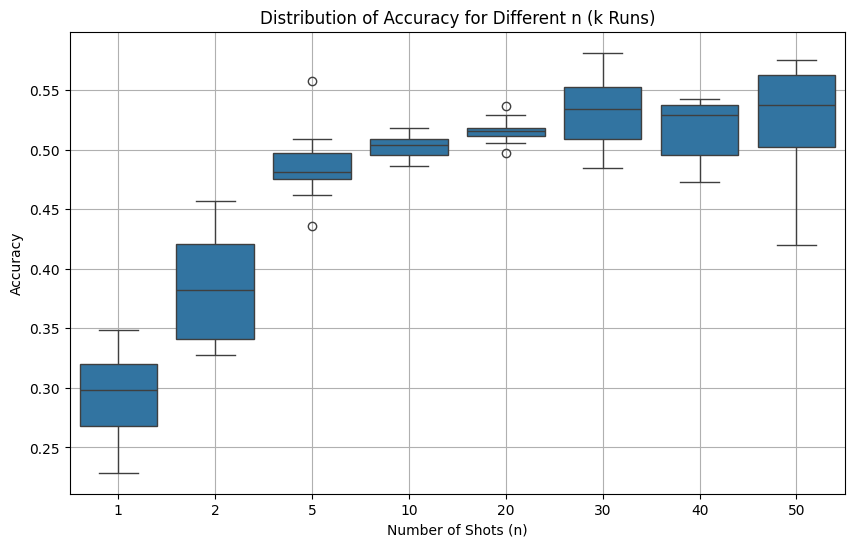

In [26]:
from src.viz import plot_from_list_acc
from src.test_model import test_n_shot


k = 10
list_acc = {}

for n in tqdm([1, 2, 5, 10, 20, 30, 40, 50]):
    accuracies = []
    for _ in range(k):
        acc = test_n_shot(model, n=n, return_logs=False)
        accuracies.append(acc)
    list_acc[n] = accuracies

plot_from_list_acc(list_acc)